In [1]:
from funcs.notebook import *
from scipy.fftpack import fft

In [2]:
def select_window_length(flux, minwinlength=75):
    """Performs an FFT and defines a window
    length that is smaller than the most prominent
    frequency.
    
    Parameters:
    -----------
    flux : array
        
    Return:
    --------
    odd int
    """
    #normalize flux and FFT it:
    yf = np.abs(fft(flux / np.nanmean(flux) - 1.))
    
    
    maxfreq = len(yf) // minwinlength * 3
    minfreq = 1

    # choose window length
    w = np.rint(len(yf) / (minfreq + np.argmax(yf[minfreq:maxfreq])) / 3)
   
    # w must be odd
    if w%2==0:
        w += 1
    
    # maximum window length is 1/3 of the chunk
    return int(max(w, minwinlength))

In [3]:
time = np.arange(10,10 + 12*np.pi,.01)
flux = np.random.normal(0,5,time.shape[0]) + 400. + 10*np.sin(2.5*time)
len(time)/3

1256.6666666666667

In [4]:
assert select_window_length(flux) == int(np.rint(time.shape[0]/6/2.5/3 + 1.))

In [5]:
flux = np.random.normal(0,5,time.shape[0]) + 400. + 10*np.sin(5*time)
select_window_length(flux) == 75 # minimum length


flux = np.random.normal(0,5,time.shape[0]) + 400. + 10*np.sin(.5*time)
assert select_window_length(flux) == int(np.rint(time.shape[0]/6/.5/3))

flux = np.random.normal(0,5,time.shape[0]) + 400. + 10*np.sin(.007*time)
select_window_length(flux), np.rint(len(time)/3)

(1257, 1257.0)

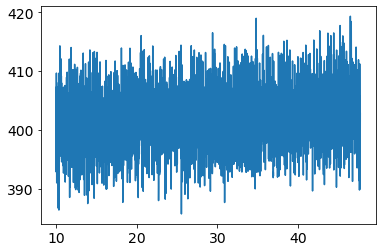

In [6]:
%matplotlib inline
plt.plot(time, flux);

In [7]:
# plt.plot(yf)
plt.plot(yf)
# plt.ylim(0,5)
plt.xlim(0,100)

NameError: name 'yf' is not defined

In [ ]:
assert w==

In [ ]:
from altaipony.altai import detrend_savgol
from altaipony.flarelc import FlareLightCurve

In [ ]:
time = np.arange(10,10 + 12*np.pi,.01)
flux = np.random.normal(0,15,time.shape[0]) + 400. + 20*np.sin(2.5*time)
err = np.random.normal(0,15,time.shape[0]) 
lc = FlareLightCurve(time=time, flux=flux, flux_err=err)
lc.plot()

In [ ]:
lc = detrend_savgol(lc, window_length=75, pad=3, printwl=True)

In [ ]:
plt.plot(lc.time, lc.detrended_flux)
plt.plot(lc.time, lc.flux)

In [ ]:
np.std(lc.detrended_flux)

In [ ]:
def detrend_savgol(lc, window_length=None, pad=3, printwl=False, **kwargs):
    '''Construct a model light curve.
    Based on original Apppaloosa (Davenport 2016)
    with Savitzky-Golay filtering from scipy,
    and iterative sigma_clipping adopted 
    from K2SC (Aigrain et al. 2016).

    
    Parameters:
    ------------
    flc : FlareLightCurve
        TESS light curve
    window_length : int
        number of datapoints for Sav.-Gol. filter,
        either one value for entire light curve
        of piecewise for gaps
    pad : int
        mask this number of data points before and
        after each outlier. Note that sigma_clip
        already expands the mask 
    printwl : bool
        if True will print final window_length
    kwargs : dict
        keyword arguments to pass to :func:`utils.sigma_clip`
    
    Return:
    -------
    FlareLightCurve
    '''
    
    lc = lc[np.where(~np.isnan(lc.flux))]
    lc.detrended_flux = np.full_like(lc.flux, np.nan)
    lc.flux_model = np.full_like(lc.flux, np.nan)
    lc.detrended_flux_err = lc.flux_err
    
    if lc.gaps is None:
        lc = lc.find_gaps()
    if (isinstance(window_length, tuple) or isinstance(window_length, list)):
        gaps = [(window_length[i], lc.gaps[i][0], lc.gaps[i][1]) for i in range(len(lc.gaps))]
    elif isinstance(window_length, int):
        gaps = [(window_length, lc.gaps[i][0], lc.gaps[i][1]) for i in range(len(lc.gaps))]
    elif window_length is None:
        gaps = [(-999, lc.gaps[i][0], lc.gaps[i][1]) for i in range(len(lc.gaps))]
    
    for (wl,le,ri) in gaps:
        
        # Do the iterative sigma clipping
        ok = np.where(sigma_clip(lc.flux[le:ri]))[0] + le
        outliers = list(set(list(range(le, ri))) - set(ok)) # inverse of ok
        
        time = lc.time[ok]
        flux = lc.flux[ok]
        error = lc.flux_err[ok]
        
        # ----------------------------------
        # Main detrending happens here:
        
        # This is from Appaloosa: 
        if wl == -999:
            dt = np.nanmedian(time[1:] - time[0:-1])
            wl = np.floor(.1 / dt)
            if wl % 2 == 0:
                wl = wl + 1
        
        # args are flux, window_length, polyorder, mode is 
        wl = max(wl, 5) #wl must be larger than polyorder
        if printwl: 
            print(f"window length: {wl}")
        flux_model_i = savgol_filter(flux, wl, 3, mode='nearest')
        
        flux_diff = flux - flux_model_i + np.nanmean(flux_model_i)
        lc.detrended_flux[ok] = flux_diff
        lc.flux_model[ok] = flux_model_i
        
        # Find out where outlier begin and end:
        a = np.isnan(lc.detrended_flux[le:ri]).astype(int)
        
        #pad outliers-------------------
       # print(np.where(a)[0])
        x = np.where(a)[0]
        for i in range(-pad,pad+1):
            y = x+i
            y[np.where(y>len(a)-1)] = len(a)-1
            a[y] = True
        #print(list(np.where(a)[0]))
        #--------------------------------
        lc.detrended_flux[le:ri][a] = np.nan

In [ ]:
a = np.ones(25).astype(int)
a[3] = 0
a[[15,16]] = 0
expand_mask(copy.deepcopy(a), longdecay=2)

In [ ]:
# check result
assert (expand_mask(copy.deepcopy(a)) == np.array([1, 1, 1, 0, 1,
                                    1, 1, 1, 1, 1,
                                    1, 1, 0, 0, 0,
                                    0, 0, 0, 0, 0,
                                    0, 0, 0, 1, 1])).all()

# this breaks the function:
a[7] = np.nan

# check that it does
with pytest.raises(ValueError) as e:
    expand_mask(copy.deepcopy(a))

In [ ]:
a = a.astype(int)
a

In [ ]:
%timeit expand_mask(a)

In [ ]:
%timeit expand_maskn(a)

In [ ]:
~isflare * 1

In [ ]:
assert (~isflare * 1 == np.array([1, 1, 1, 0, 1,
                                  1, 1, 1, 1, 1,
                                  1, 1, 0, 0, 0,
                                  0, 0, 0, 0, 0,
                                  0, 0, 0, 1, 1])).all()

In [ ]:
a[np.where(a==0)]=np.nan
np.cumsum(a)

In [ ]:
np.cumsum(a[np.where(a>0)])

In [ ]:
reverse_counts